# Diabetic Retinopathy Analysis

Student Name: Michael Tsypin

Instructor Name: Morgan Jones

Date: 6/14/2024

---

## Overview

Diabetic retinopathy (DR) is the leading cause of vision loss in the world. The use of early detection and treatment of DR is imperative in preventing vision loss. However, the current method of DR identification is time consuming and erroneous as it requires manual labor which can potentially lead to incorrect diagnosis of DR. This project aims to create a model that can predict whether a patient has diabetic retinopathy or not based on a retinal image. 

## Business Problem

An Opthalmology unit of a hospital wants to make more accurate diagnoses and reduce the amount of time spent reviewing retinal images for diabetic retinopathy. We need to create a model that is able to read and analyze retinal images to determine if a patient has diabetic retinopathy. Using the diabetic retinopathy dataset, this model will be effective in producing mass results and accurate readings in a timely manner.

## Data Understanding

This data comes from Kaggle and is provided by user Parisa Karimi Darabi. The dataset used in this project contains many retinal images captured through various imaging procedures, such as color fundus photos and optical coherence tomography. A medical professional assessed the diagnosis of each retinal image and classified each image as having diabetic retinopathy or not.

Data link: https://www.kaggle.com/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy/data

### Importing

We will begin by importing the necessary libraries to work on this project.

In [1]:
#Import libraries
from tensorflow import keras 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
from keras import models
from keras import layers
from keras import optimizers
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input, Flatten, Dropout
from keras.regularizers import l2

### Data Preparation

In [2]:
#Get train data from train dataset
train_folder = os.path.join('diabetic_retinopathy/train')
train_dr = os.path.join(train_folder, 'DR')
train_no_dr = os.path.join(train_folder, 'No_DR')

#Get test data from test dataset
test_folder = os.path.join('diabetic_retinopathy/test')
test_dr = os.path.join(test_folder, 'DR')
test_no_dr = os.path.join(test_folder, 'No_DR')

#Get validation data from valid dataset
val_folder = os.path.join('diabetic_retinopathy/valid')
val_dr = os.path.join(val_folder, 'DR')
val_no_dr = os.path.join(val_folder, 'No_DR')

In [3]:
#Look at train_dr
train_dr

'diabetic_retinopathy/train/DR'

In [4]:
#Print number of DR images in training set
print('There are', len(os.listdir(train_dr)), 'diabetic retinopathy images in the training set')

There are 1050 diabetic retinopathy images in the training set


In [5]:
#Print number of normal images in training set
print('There are', len(os.listdir(train_no_dr)), 'normal images in the training set')

There are 1026 normal images in the training set


In [6]:
#Print number of DR images in test set
print('There are', len(os.listdir(test_dr)), 'diabetic retinopathy images in the test set')

There are 113 diabetic retinopathy images in the test set


In [7]:
#Print number of normal images in test set
print('There are', len(os.listdir(test_no_dr)), 'normal images in the test set')

There are 118 normal images in the test set


In [8]:
#Print number of DR images in validation set
print('There are', len(os.listdir(val_dr)), 'diabetic retinopathy images in the validation set')

There are 245 diabetic retinopathy images in the validation set


In [9]:
#Print number of normal images in validation set
print('There are', len(os.listdir(val_no_dr)), 'normal images in the validation set')

There are 286 normal images in the validation set


We have a total of 2838 images across the train, test, and validation sets that are categorized as either normal or pneumonia.

In [10]:
#Create list of labels in train dataset
labels_train = []

for i in ['DR','no_DR']:
    files_train = os.listdir(f"diabetic_retinopathy/train/{i}")
    for l in range(len(files_train)):
        labels_train.append(i)

In [11]:
#Create label encoder
label_en = LabelEncoder()

labels_all = label_en.fit_transform(labels_train)

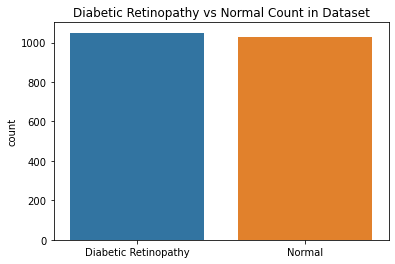

In [12]:
#Create countplot showing number of diabetic retinopathy images vs normal within dataset
sns.countplot(labels_all).set(title = "Diabetic Retinopathy vs Normal Count in Dataset", xticklabels=["Diabetic Retinopathy", "Normal"]);

The plot shown above depicts the count of the number of retinal images with diabetic retinopathy within the training dataset versus the number of normal retinal images in the training dataset. Here we see that there is roughly the same amount of diabetic retinopathy images compared to the number of normal images (1050 vs 1026 to be exact). 

In [13]:
# get all the data in the directory diabetic_retinopathy/test (231 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224, 224), batch_size = 231) 

# get all the data in the directory diabetic_retinopathy/validation (531 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(224, 224), batch_size = 531) 

# get all the data in the directory diabetic_retinopathy/train (2076 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(224, 224), batch_size = 2076) 

Found 231 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 2076 images belonging to 2 classes.


In [14]:
#Run train, test, and validation sets through generators
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

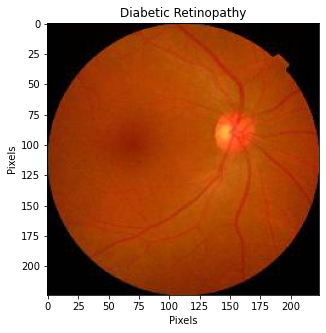

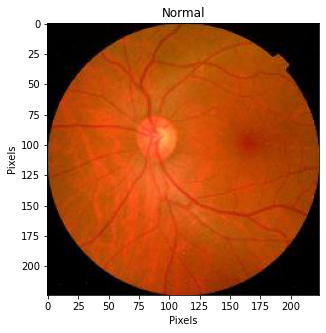

In [15]:
#Show image of DR
plt.figure(figsize = (5,5))
plt.imshow(train_images[0], cmap='gray')
plt.title("Diabetic Retinopathy")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

#Show image of no DR
plt.figure(figsize = (5,5))
plt.imshow(train_images[-1], cmap='gray')
plt.title("Normal")
plt.xlabel("Pixels")
plt.ylabel("Pixels");

The top image shows an example of a retinal image of a patient with diabetic retinopathy from the training set. The bottom image shows an example of a normal retinal image from the training set.

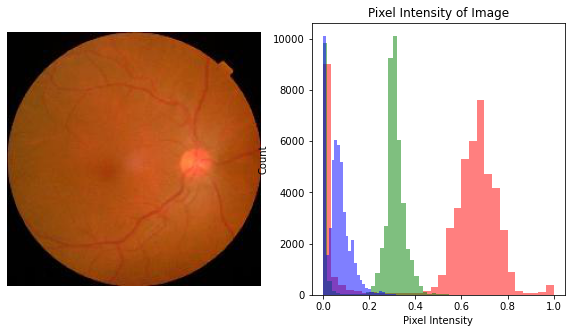

In [16]:
#Create histogram of pixel intensity
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(train_images[1])
plt.axis('off')
histogram = plt.subplot(1,2,2)
histogram.set_title("Pixel Intensity of Image")
histogram.set_ylabel('Count')
histogram.set_xlabel('Pixel Intensity')
n_bins = 30
plt.hist(train_images[1][:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.hist(train_images[1][:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
plt.hist(train_images[1][:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

The image on the right depicts a histogram of the pixel intensity of the retinal image shown on the left.

In [17]:
# Explore dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 2076
Number of testing samples: 231
Number of validation samples: 531
train_images shape: (2076, 224, 224, 3)
train_labels shape: (2076, 2)
test_images shape: (231, 224, 224, 3)
test_labels shape: (231, 2)
val_images shape: (531, 224, 224, 3)
val_labels shape: (531, 2)


In [18]:
#Reshape data sets
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(2076, 150528)
(231, 150528)
(531, 150528)


In [19]:
#Reshape data sets
train_y = np.reshape(train_labels[:,0], (2076,1))
test_y = np.reshape(test_labels[:,0], (231,1))
val_y = np.reshape(val_labels[:,0], (531,1))

### Modeling

#### Baseline

We will now proceed with our baseline model. We will use this baseline model to compare with future models in order to determine how successful our future model's results are.

In [20]:
#Create baseline model
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(20, activation='relu', input_shape=(150528,)))
baseline_model.add(layers.Dense(7, activation='relu'))
baseline_model.add(layers.Dense(5, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
#Compile the baseline model
baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
#Print summary of baseline model
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                3010580   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 3,010,773
Trainable params: 3,010,773
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Train the baseline model
history = baseline_model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
65/65 [==============================] - 1s 16ms/step - loss: 0.7139 - accuracy: 0.6546 - val_loss: 0.5898 - val_accuracy: 0.8663
Epoch 2/50
65/65 [==============================] - 1s 14ms/step - loss: 0.5094 - accuracy: 0.8324 - val_loss: 0.4861 - val_accuracy: 0.8682
Epoch 3/50
65/65 [==============================] - 1s 14ms/step - loss: 0.4516 - accuracy: 0.8772 - val_loss: 0.4547 - val_accuracy: 0.8682
Epoch 4/50
65/65 [==============================] - 1s 13ms/step - loss: 0.4215 - accuracy: 0.8863 - val_loss: 0.4289 - val_accuracy: 0.8682
Epoch 5/50
65/65 [==============================] - 1s 14ms/step - loss: 0.3979 - accuracy: 0.8945 - val_loss: 0.3939 - val_accuracy: 0.8870
Epoch 6/50
65/65 [==============================] - 1s 14ms/step - loss: 0.3759 - accuracy: 0.9037 - val_loss: 0.3820 - val_accuracy: 0.8795
Epoch 7/50
65/65 [==============================] - 1s 13ms/step - loss: 0.3539 - accuracy: 0.9118 - val_loss: 0.4026 - val_accuracy: 0.8682
Epoch 8/50
65

In [24]:
#Get training loss and accuracy results
results_train = baseline_model.evaluate(train_img, train_y)

65/65 [==============================] - 0s 6ms/step - loss: 0.2008 - accuracy: 0.9316


In [25]:
#View train results
results_train

[0.2007663995027542, 0.9315991997718811]

In [26]:
#Create predictions
predictions = baseline_model.predict_classes(test_img)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [27]:
#Check accuracy 
print('Testing accuracy: ', accuracy_score(test_y, predictions))

Testing accuracy:  0.935064935064935


In [28]:
#Check recall
print('Testing recall: ', recall_score(test_y, predictions))

Testing recall:  0.8849557522123894


A positive result in this instance is classified as having diabetic retinopathy. We will be using recall as the metric to determine how well our models perform. The recall formula is the number of true positives divided by the sum of the number of true positives and false negatives identified by the model. The results of our baseline model show that the test set had a recall score of 0.8850. We will use the testing recall as a baseline when comparing future models to determine success of that model.

In [29]:
#Create function to graph accuracy vs number of epochs and loss vs number of epochs for training and validation data
def accuracy_loss_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

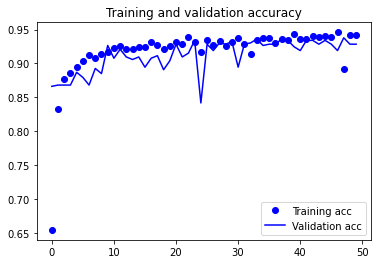

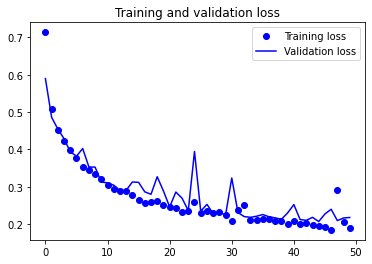

In [30]:
#Call accuracy_loss_graph function on baseline history
accuracy_loss_graph(history)

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our baseline model results.

#### Normalization

We will now try tuning our neural network using normalization.

In [31]:
#Create model 2
model_2 = models.Sequential()
model_2.add(layers.Dense(20, activation='relu', input_shape=(150528,)))
model_2.add(BatchNormalization())
model_2.add(layers.Dense(7, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(layers.Dense(5, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [32]:
#Compile model 2
model_2.compile(optimizer='sgd',
             loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
#Print summary of model 2
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                3010580   
_________________________________________________________________
batch_normalization (BatchNo (None, 20)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 147       
_________________________________________________________________
batch_normalization_1 (Batch (None, 7)                 28        
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 3,010,881
Trainable params: 3,010,827
Non-trainable params: 54
___________________________________________

In [34]:
#Train model 2
history_2 = model_2.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
65/65 [==============================] - 1s 17ms/step - loss: 0.3923 - accuracy: 0.8574 - val_loss: 0.5321 - val_accuracy: 0.8682
Epoch 2/50
65/65 [==============================] - 1s 14ms/step - loss: 0.3066 - accuracy: 0.8887 - val_loss: 0.3520 - val_accuracy: 0.8964
Epoch 3/50
65/65 [==============================] - 1s 14ms/step - loss: 0.2836 - accuracy: 0.8902 - val_loss: 0.7451 - val_accuracy: 0.5009
Epoch 4/50
65/65 [==============================] - 1s 13ms/step - loss: 0.2413 - accuracy: 0.9133 - val_loss: 0.3186 - val_accuracy: 0.8964
Epoch 5/50
65/65 [==============================] - 1s 13ms/step - loss: 0.2382 - accuracy: 0.9075 - val_loss: 0.2342 - val_accuracy: 0.9058
Epoch 6/50
65/65 [==============================] - 1s 14ms/step - loss: 0.2144 - accuracy: 0.9200 - val_loss: 0.2667 - val_accuracy: 0.8945
Epoch 7/50
65/65 [==============================] - 1s 14ms/step - loss: 0.2030 - accuracy: 0.9263 - val_loss: 0.2273 - val_accuracy: 0.9096
Epoch 8/50
65

In [35]:
#Get training loss and accuracy of model 2
results_train_2 = model_2.evaluate(train_img, train_y)

65/65 [==============================] - 0s 6ms/step - loss: 0.2368 - accuracy: 0.9152


In [36]:
#View train results
results_train_2

[0.2367771714925766, 0.9152215719223022]

In [37]:
#Create predictions
predictions_2 = model_2.predict_classes(test_img)

In [38]:
#Check accuracy
print('Testing accuracy: ', accuracy_score(test_y, predictions_2))

Testing accuracy:  0.8831168831168831


In [39]:
#Check recall
print('Testing recall: ', recall_score(test_y, predictions_2))

Testing recall:  0.7876106194690266


Our normalization model has a test recall score of 0.7876, which is worse compared to our baseline model. Since normalization did not improve the recall score, we will attempt to increase the recall score by performing a Convolutional Neural Network (CNN).

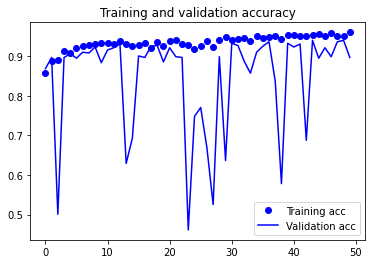

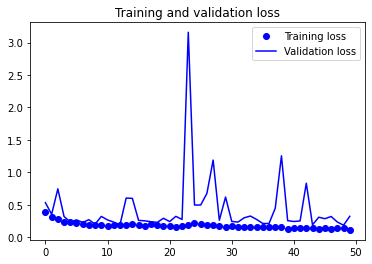

In [40]:
#Call accuracy_loss_graph function on model 2 history
accuracy_loss_graph(history_2)

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our normalization model results.

#### CNN

In [41]:
#Create model 3
model_3 = models.Sequential()
model_3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224 ,224,  3)))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

In [42]:
#Compile model 3
model_3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [43]:
#Print summary of model 3
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 32)      16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)            

In [44]:
#Train model 3
history_3 = model_3.fit(train_images,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/50
65/65 [==============================] - 52s 801ms/step - loss: 0.5927 - accuracy: 0.6850 - val_loss: 0.4512 - val_accuracy: 0.8098
Epoch 2/50
65/65 [==============================] - 52s 802ms/step - loss: 0.4274 - accuracy: 0.7958 - val_loss: 0.3103 - val_accuracy: 0.8588
Epoch 3/50
65/65 [==============================] - 53s 814ms/step - loss: 0.3383 - accuracy: 0.8550 - val_loss: 0.2697 - val_accuracy: 0.8814
Epoch 4/50
65/65 [==============================] - 51s 790ms/step - loss: 0.2816 - accuracy: 0.8868 - val_loss: 0.2571 - val_accuracy: 0.8832
Epoch 5/50
65/65 [==============================] - 51s 791ms/step - loss: 0.2841 - accuracy: 0.8858 - val_loss: 0.2974 - val_accuracy: 0.8719
Epoch 6/50
65/65 [==============================] - 51s 788ms/step - loss: 0.2732 - accuracy: 0.8897 - val_loss: 0.2457 - val_accuracy: 0.8908
Epoch 7/50
65/65 [==============================] - 51s 786ms/step - loss: 0.2654 - accuracy: 0.8931 - val_loss: 0.2495 - val_accuracy: 0.8776

In [45]:
#Get training loss and accuracy of model 3
results_train_3 = model_3.evaluate(train_images, train_y)

65/65 [==============================] - 10s 153ms/step - loss: 0.1309 - accuracy: 0.9533


In [46]:
#View train results
results_train_3

[0.13092130422592163, 0.9532755017280579]

In [47]:
#Make predictions
predictions_3 = model_3.predict_classes(test_images)

In [48]:
#Check accuracy
print('Testing accuracy: ', accuracy_score(test_y, predictions_3))

Testing accuracy:  0.9393939393939394


In [49]:
#Check recall
print('Testing recall: ', recall_score(test_y, predictions_3))

Testing recall:  0.9380530973451328


Using a CNN model, we were able to achieve a higher recall score compared to our baseline model. This CNN has a recall score of 0.9381 which is significantly higher than our baseline.

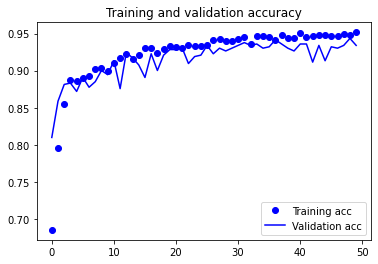

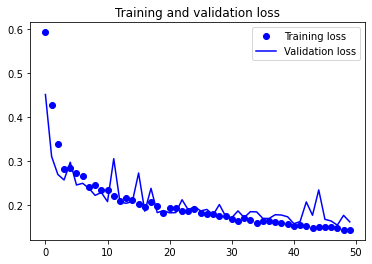

In [50]:
#Call accuracy_loss_graph function on model 3 history
accuracy_loss_graph(history_3)

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our CNN model results.

We will now try to improve our score by making modifications to the CNN by making slight changes to the layers within the CNN.

In [51]:
#Create model 4
model_4 = models.Sequential()
model_4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224 , 224,  3)))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(128, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

In [52]:
#Compile model 4
model_4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [53]:
#View summary of model 4
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 108, 108, 64)      32832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 86528)            

In [54]:
#Train model 4
history_4 = model_4.fit(train_images,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/50
65/65 [==============================] - 61s 941ms/step - loss: 0.6045 - accuracy: 0.7250 - val_loss: 0.5102 - val_accuracy: 0.6215
Epoch 2/50
65/65 [==============================] - 64s 981ms/step - loss: 0.4197 - accuracy: 0.8059 - val_loss: 0.2974 - val_accuracy: 0.8776
Epoch 3/50
65/65 [==============================] - 62s 959ms/step - loss: 0.3231 - accuracy: 0.8579 - val_loss: 0.3040 - val_accuracy: 0.8644
Epoch 4/50
65/65 [==============================] - 64s 988ms/step - loss: 0.2837 - accuracy: 0.8738 - val_loss: 0.3066 - val_accuracy: 0.8663
Epoch 5/50
65/65 [==============================] - 63s 965ms/step - loss: 0.2824 - accuracy: 0.8820 - val_loss: 0.2685 - val_accuracy: 0.8776
Epoch 6/50
65/65 [==============================] - 60s 921ms/step - loss: 0.2533 - accuracy: 0.8964 - val_loss: 0.2388 - val_accuracy: 0.8983
Epoch 7/50
65/65 [==============================] - 72s 1s/step - loss: 0.2472 - accuracy: 0.9013 - val_loss: 0.2224 - val_accuracy: 0.9058
Ep

In [55]:
#Get training loss and accuracy of model 4
results_train_4 = model_4.evaluate(train_images, train_y)

65/65 [==============================] - 13s 199ms/step - loss: 0.1180 - accuracy: 0.9562


In [56]:
#View train results
results_train_4

[0.11796174198389053, 0.9561657309532166]

In [57]:
#Make predictions
predictions_4 = model_4.predict_classes(test_images)

In [58]:
#Check accuracy
print('Testing accuracy: ', accuracy_score(test_y, predictions_4))

Testing accuracy:  0.922077922077922


In [59]:
#Check recall
print('Testing recall: ', recall_score(test_y, predictions_4))

Testing recall:  0.9380530973451328


Modifying our CNN did not see any change to our recall score as this CNN now has a recall score of about 94%, which is very similar to the previous CNN result.

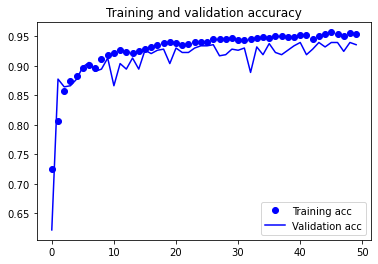

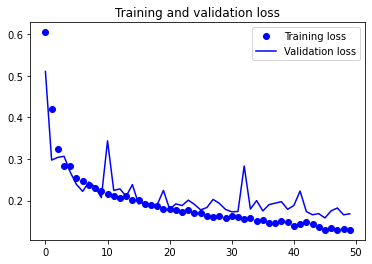

In [60]:
#Call accuracy_loss_graph function on model 3 history
accuracy_loss_graph(history_4)

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our CNN model results.

#### Transfer Learning

Tranfer learning involves the use of a pretrained dataset, which is a saved model that was ran with a large, general dataset. This is useful as we can run a smaller dataset, such as our diabetic retinopathy dataset, through this pretrained model to obtain even better results. We will be using the VGG19 model and will have to modify the network to be able to take in our retinal images. 

In [61]:
#Write function to create vgg19 model
def CNN_Model():
    base_model = VGG19(weights='imagenet', include_top = False, input_shape=(224, 224, 3))
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    for i in range(3):
        base_model.layers[-2-i].trainable = True

    CNN = Sequential()
    CNN.add(Input(shape=(224, 224,3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.3))
    CNN.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(1, activation='sigmoid'))
    
    return CNN

# Training The CNN
model_vgg19 = CNN_Model()
model_vgg19.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model_vgg19.summary()  

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 23,235,905
Trainable params: 10,290,945
Non-trainable params: 12,944,960
_________________________________

In [62]:
#Train model vgg19
history_vgg19 = model_vgg19.fit(train_images,
                    train_y,
                    epochs=25,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/25
65/65 [==============================] - 272s 4s/step - loss: 12.4657 - accuracy: 0.8107 - val_loss: 11.4195 - val_accuracy: 0.9303
Epoch 2/25
65/65 [==============================] - 307s 5s/step - loss: 10.7459 - accuracy: 0.9128 - val_loss: 10.0422 - val_accuracy: 0.9284
Epoch 3/25
65/65 [==============================] - 303s 5s/step - loss: 9.4537 - accuracy: 0.9224 - val_loss: 8.8283 - val_accuracy: 0.9322
Epoch 4/25
65/65 [==============================] - 308s 5s/step - loss: 8.2989 - accuracy: 0.9335 - val_loss: 7.7648 - val_accuracy: 0.9228
Epoch 5/25
65/65 [==============================] - 325s 5s/step - loss: 7.3039 - accuracy: 0.9374 - val_loss: 6.8360 - val_accuracy: 0.9341
Epoch 6/25
65/65 [==============================] - 307s 5s/step - loss: 6.4322 - accuracy: 0.9436 - val_loss: 6.0189 - val_accuracy: 0.9322
Epoch 7/25
65/65 [==============================] - 302s 5s/step - loss: 5.6588 - accuracy: 0.9422 - val_loss: 5.3036 - val_accuracy: 0.9360
Epoch 8/2

In [63]:
#Get training loss and accuracy of model vgg19
results_train_vgg19 = model_vgg19.evaluate(train_images, train_y)

65/65 [==============================] - 200s 3s/step - loss: 0.5935 - accuracy: 0.9730


In [64]:
#View train results
results_train_vgg19

[0.5934693813323975, 0.9730250239372253]

In [65]:
#Make predictions
predictions_vgg19 = model_vgg19.predict_classes(test_images)

In [66]:
#Check accuracy
print('Testing accuracy: ', accuracy_score(test_y, predictions_vgg19))

Testing accuracy:  0.948051948051948


In [67]:
#Check recall
print('Testing recall: ', recall_score(test_y, predictions_vgg19))

Testing recall:  0.9469026548672567


The VGG19 model is our best performing model with a recall score of 0.9469.

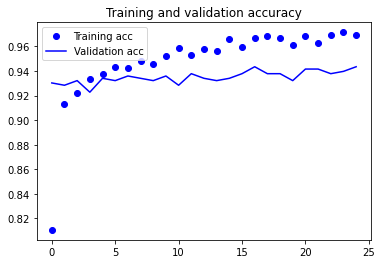

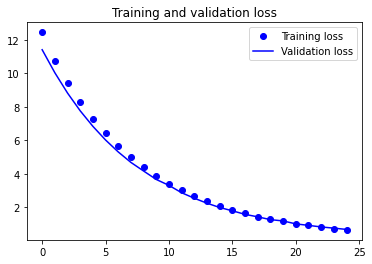

In [68]:
#Call accuracy_loss_graph function on model vgg19 history
accuracy_loss_graph(history_vgg19)

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our VGG19 model results.

In [69]:
#Print classification report
print(classification_report(test_y, predictions_vgg19, target_names = ['DR (Class 0)','Normal (Class 1)']))

                  precision    recall  f1-score   support

    DR (Class 0)       0.95      0.95      0.95       118
Normal (Class 1)       0.95      0.95      0.95       113

        accuracy                           0.95       231
       macro avg       0.95      0.95      0.95       231
    weighted avg       0.95      0.95      0.95       231



In [70]:
#Print confusion matrix
cm = confusion_matrix(test_y,predictions_vgg19)
cm

array([[112,   6],
       [  6, 107]])

In [71]:
#Convey confusion matrix to dataframe
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

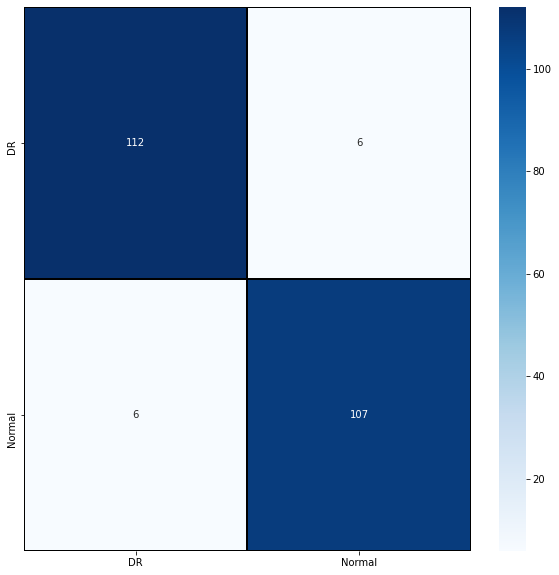

In [72]:
#Graph confusion matrix
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ["DR", "Normal"],yticklabels = ["DR", "Normal"]);

Here we have a confusion matrix which tells us the amount of True Positives (top left corner), False Positives (bottom left corner), False Negatives (top right corner), and True Negatives (bottom right corner). False negatives are the most detrimental of the four. A false negative in this scenario is when our model predicts the image to be normal, when in reality, there is diabetic retinopathy. This is extremely harmful to the patient as this misdiagnosis can potentially lead to vision loss as diabetic retinopathy was not identified and therefore not treated. Our model has only identified 6 false negatives.

#### Data Augmentation

In an attempt to create more data for training, we can generate synthetic data by slightly altering the images already present in the data set. This method can potentially create even more accurate scores, as our models will have more data to read and digest.

In [73]:
#Create train_data_generator to create synthetic data
train_data_generator = ImageDataGenerator(rescale=1./255, 
        rotation_range = 20, 
        zoom_range = 0.2, 
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip = True,  
        vertical_flip=False)

The new images will be rotated by 20 degrees, zoomed in by 20%, shift the width and height of the images by a two tenths of a fraction, and horizontally flip the images.

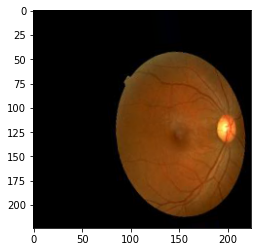

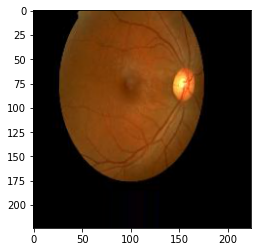

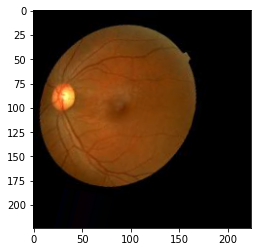

In [74]:
#Show slightly altered synthetic images
names = [os.path.join(train_no_dr, name) for name in os.listdir(train_no_dr)]
img_path = names[91]
img = load_img(img_path, target_size=(224, 224))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
i=0
for batch in train_data_generator.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()

Here we see three examples of the same image from our new synthetic data. All three images have slight variations to make each image unqiue.

In [75]:
# get all the data in the directory test (231 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        batch_size = 231,
        class_mode='binary') 

# get all the data in the directory val, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(224, 224),
        batch_size = 32,
        class_mode='binary')

# get all the data in the directory train , and reshape them
train_generator = train_data_generator.flow_from_directory(
        train_folder, 
        target_size=(224, 224), 
        batch_size = 32, 
        class_mode='binary')

Found 231 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 2076 images belonging to 2 classes.


We will now run our augmented data through the VGG19 model, as this is our best performing model so far.

In [88]:
#Write function to create vgg19 model
def CNN_Model():
    base_model = VGG19(weights='imagenet', include_top = False, input_shape=(224, 224, 3))
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    for i in range(3):
        base_model.layers[-2-i].trainable = True

    CNN = Sequential()
    CNN.add(Input(shape=(224, 224,3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.3))
    CNN.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(1, activation='sigmoid'))
    
    return CNN

# Training The CNN
model_vgg19_2 = CNN_Model()
model_vgg19_2.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model_vgg19_2.summary()  

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 129       
Total params: 23,235,905
Trainable params: 10,290,945
Non-trainable params: 12,944,960
_________________________________

In [89]:
#Train model vgg19
history_vgg19_2 = model_vgg19_2.fit(train_generator,
                      epochs=25,
                      validation_data=val_generator,
                      steps_per_epoch=len(train_generator),
                      validation_steps=len(test_generator))

Epoch 1/25
65/65 [==============================] - 243s 4s/step - loss: 12.6086 - accuracy: 0.7086 - val_loss: 11.8572 - val_accuracy: 0.6562
Epoch 2/25
65/65 [==============================] - 247s 4s/step - loss: 10.8854 - accuracy: 0.8526 - val_loss: 10.0143 - val_accuracy: 0.9375
Epoch 3/25
65/65 [==============================] - 276s 4s/step - loss: 9.5288 - accuracy: 0.8873 - val_loss: 8.8970 - val_accuracy: 0.8750
Epoch 4/25
65/65 [==============================] - 275s 4s/step - loss: 8.3757 - accuracy: 0.9080 - val_loss: 7.7905 - val_accuracy: 0.9375
Epoch 5/25
65/65 [==============================] - 287s 4s/step - loss: 7.3839 - accuracy: 0.9032 - val_loss: 7.0248 - val_accuracy: 0.8750
Epoch 6/25
65/65 [==============================] - 281s 4s/step - loss: 6.5081 - accuracy: 0.9066 - val_loss: 6.0227 - val_accuracy: 0.9375
Epoch 7/25
65/65 [==============================] - 269s 4s/step - loss: 5.7271 - accuracy: 0.9118 - val_loss: 5.3191 - val_accuracy: 0.9375
Epoch 8/2

In [94]:
#Run test sets through generator
test_x, test_y = next(test_generator)

In [90]:
#Make predictions on vgg19 model
predictions_vgg19_2 = model_vgg19_2.predict_classes(test_images)

In [91]:
#Check accuracy
print('Testing accuracy: ', accuracy_score(test_y, predictions_vgg19_2))

Testing accuracy:  0.4935064935064935


In [92]:
#Check recall
print('Testing recall: ', recall_score(test_y, predictions_vgg19_2))

Testing recall:  0.5254237288135594


Our score is significantly lower with a recall score of 0.5254. This low score can be explained by the data augmentation actually creating noise for our model, causing it to perform worse compared to when we ran the original dataset through the model.

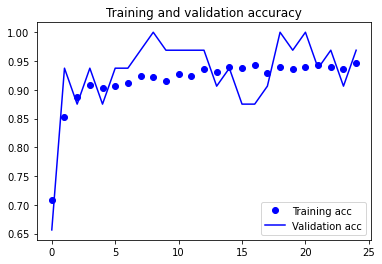

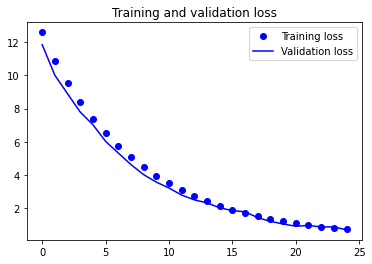

In [93]:
#Call accuracy_loss_graph function on model vgg19 2 history
accuracy_loss_graph(history_vgg19_2)

These graphs demonstrate the training/validation accuracy vs number of epochs (top image) and loss vs number of epochs (bottom image) of our VGG19 model 2 results.

### Evaluation

Now that we have ran through all of our models, we can see that the best performing model in terms of recall is our VGG19 model that we ran with our original data. This model had a recall score of 95% and had 6 false negatives identified. We will now use the LIME feature on our DR images to help with the identification of DR on the retinal images.

In [115]:
#Create explanation for lime
x=10
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
                 val_images[x], 
                model_4.predict,top_labels=2)
        

image, mask = explanation.get_image_and_mask(0,
                             hide_rest=False)


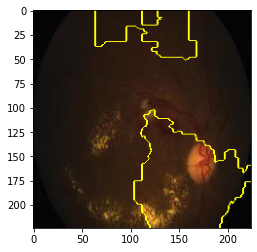

In [117]:
#Use lime on pneumonia image
plt.imshow(mark_boundaries(image, mask));

We can use LIME to help us interpret the model's results. LIME (Local Interpretable Model-agnostic Explanations) is used as an explanation of the model in how it reads and digests the image to make its decision. In the image above, we can see that the model is looking at the part of the image within the yellow outline to show us where the model sees diabetic retinopathy within the eye and therefore classifies the image as having diabetic retinopathy. LIME is also helpful to us as it can be used help an opthalmologist make a diagnosis faster by viewing the outlined part of the retinal image and help make a diagnosis.

## Conclusion

The best and final model we found based on recall score was our VGG19 model. This model has a recall score of 95%. We would recommend that the hospital use this model to feed retinal images so that an opthamologist can use the model's prediction to help determine a diagnosis of diabetic retinopathy or not. We would also recommend that the opthamologist use LIME to aid diagnosis assistance by making more accurate and quicker diagnoses using LIME outlines.